<a href="https://colab.research.google.com/github/GabrielOlem/projetoPLN/blob/main/ATIS_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMPORTS

In [2]:
import os
import pickle
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, SimpleRNN, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix

## LOAD DATASET AND GET TOKENS, SLOTS AND INTENTS, AND THEIR INDEXES

In [3]:
def load_ds(fname):
    fname = os.path.join(fname)
    with open(fname, 'rb') as stream:
        ds, dicts = pickle.load(stream)
    print('Done  loading: ', fname)
    print('      samples: {:4d}'.format(len(ds['query'])))
    print('   vocab_size: {:4d}'.format(len(dicts['token_ids'])))
    print('   slot count: {:4d}'.format(len(dicts['slot_ids'])))
    print(' intent count: {:4d}'.format(len(dicts['intent_ids'])))
    return ds, dicts

In [6]:
train_ds, dicts = load_ds('atis.train.pkl')
test_ds, _ = load_ds('atis.test.pkl')

Done  loading:  atis.train.pkl
      samples: 4978
   vocab_size:  943
   slot count:  129
 intent count:   26
Done  loading:  atis.test.pkl
      samples:  893
   vocab_size:  943
   slot count:  129
 intent count:   26


In [7]:
t2i, s2i, in2i = map(dicts.get, ['token_ids', 'slot_ids', 'intent_ids'])
i2t, i2s, i2in = map(lambda d: {d[k]: k for k in d.keys()}, [t2i, s2i, in2i])
query, slots, intent = map(train_ds.get,
                           ['query', 'slot_labels', 'intent_labels'])

In [8]:
t2i_test, s2i_test, in2i_test = map(dicts.get, ['token_ids', 'slot_ids', 'intent_ids'])
i2t_test, i2s_test, i2in_test = map(lambda d: {d[k]: k for k in d.keys()}, [t2i_test, s2i_test, in2i_test])
query_test, slots_test, intent_test = map(test_ds.get,
                           ['query', 'slot_labels', 'intent_labels'])

## FORMAT TRAIN AND TEST DATASETS

In [9]:
query_complete = query + query_test
intent_complete = intent + intent_test # TURN INTO A SINGLE DATASET
padded_x = pad_sequences(query_complete) # PAD QUERIES FOR UNIFORMIZATION
y = tf.keras.utils.to_categorical(intent_complete) # TURN Y FROM CATEGORICAL TO ONE_HOT_ENCODING

In [10]:
X_train, X_test, y_train, y_test = train_test_split(padded_x, y, test_size=0.2, random_state=42)

## HYPERPARAMETERS

In [11]:
INPUT_LENGTH = 48
EMBEDDING_SIZE = 100
UNITS = 128
DROPOUT = 0.2
### Training parameters
LOSS = "categorical_crossentropy"
OPTIMIZER = "adam"
BATCH_SIZE = 32
EPOCHS = 8
LABELS = 26
EMBEDDING_DIMS = len(dicts['token_ids'])+1

## FUNCTION THAT CREATES THE MODEL

In [12]:
def create_model(type, embedding_dims, embedding_size, input_length, units, dropout, labels):
    model = Sequential()
    model.add(Embedding(embedding_dims, embedding_size, input_length=input_length))
    model.add(type(units, return_sequences=True)) #p/ mais de uma camada
    model.add(Dropout(dropout))
    model.add(type(units,return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(labels, activation='softmax'))
    return model

## FUNCTION THAT EVALUATES THE MODEL AND GENERATES THE CONFUSION MATRIX

In [13]:
def evaluate_model(model, X_test, y_test):
    Y_pred = model.predict(X_test)
    
    Y_pred_max = tf.argmax(tf.nn.softmax(Y_pred), -1).numpy().flatten()
    y_test_max =tf.argmax(y_test, axis=-1).numpy().flatten()
    y_no_pad = [(p,y) for p,y in zip(Y_pred_max, y_test_max) if y != 0]
    pred = [x[0] for x in y_no_pad]
    true = [x[1] for x in y_no_pad]

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(confusion_matrix(pred, true), annot=True, vmax=100, ax=ax)

    print(classification_report(pred, true, zero_division=False))

## MODEL CREATION AND COMPILING
Here we compare 3 different models: LSTM, RNN and GRU

## LSTM

In [14]:
model_LSTM = create_model(LSTM, EMBEDDING_DIMS, EMBEDDING_SIZE, INPUT_LENGTH, UNITS, DROPOUT, LABELS)
model_LSTM.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=["accuracy"])
model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 48, 100)           94400     
                                                                 
 lstm (LSTM)                 (None, 48, 128)           117248    
                                                                 
 dropout (Dropout)           (None, 48, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 26)                3354      
                                                                 
Total params: 346,586
Trainable params: 346,586
Non-trai

In [15]:
history = model_LSTM.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs=EPOCHS,validation_split=0.15,verbose=2)

Epoch 1/8
125/125 - 13s - loss: 1.3462 - accuracy: 0.7201 - val_loss: 1.0954 - val_accuracy: 0.7518 - 13s/epoch - 104ms/step
Epoch 2/8
125/125 - 3s - loss: 1.1999 - accuracy: 0.7269 - val_loss: 0.8764 - val_accuracy: 0.7801 - 3s/epoch - 27ms/step
Epoch 3/8
125/125 - 3s - loss: 0.7471 - accuracy: 0.8056 - val_loss: 0.5298 - val_accuracy: 0.8596 - 3s/epoch - 27ms/step
Epoch 4/8
125/125 - 3s - loss: 0.4766 - accuracy: 0.8717 - val_loss: 0.3791 - val_accuracy: 0.9007 - 3s/epoch - 27ms/step
Epoch 5/8
125/125 - 3s - loss: 0.3589 - accuracy: 0.8990 - val_loss: 0.2888 - val_accuracy: 0.9220 - 3s/epoch - 26ms/step
Epoch 6/8
125/125 - 3s - loss: 0.2362 - accuracy: 0.9339 - val_loss: 0.2359 - val_accuracy: 0.9433 - 3s/epoch - 26ms/step
Epoch 7/8
125/125 - 3s - loss: 0.1787 - accuracy: 0.9514 - val_loss: 0.2365 - val_accuracy: 0.9433 - 3s/epoch - 26ms/step
Epoch 8/8
125/125 - 3s - loss: 0.1311 - accuracy: 0.9682 - val_loss: 0.2204 - val_accuracy: 0.9475 - 3s/epoch - 26ms/step


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.93      0.93      0.93        15
           2       0.00      0.00      0.00         0
           3       0.98      0.93      0.95       100
           4       0.00      0.00      0.00         0
           6       1.00      0.94      0.97        49
           8       0.71      0.56      0.63         9
           9       0.50      1.00      0.67         5
          11       0.00      0.00      0.00         0
          13       1.00      0.24      0.38        17
          14       0.98      0.99      0.99       863
          15       0.80      0.36      0.50        11
          17       0.00      0.00      0.00         0
          19       0.75      0.50      0.60        12
          20       0.60      1.00      0.75         3
          21       0.96      0.96      0.96        48
          23       0.00      0.00      0.00         0
          24       0.65    

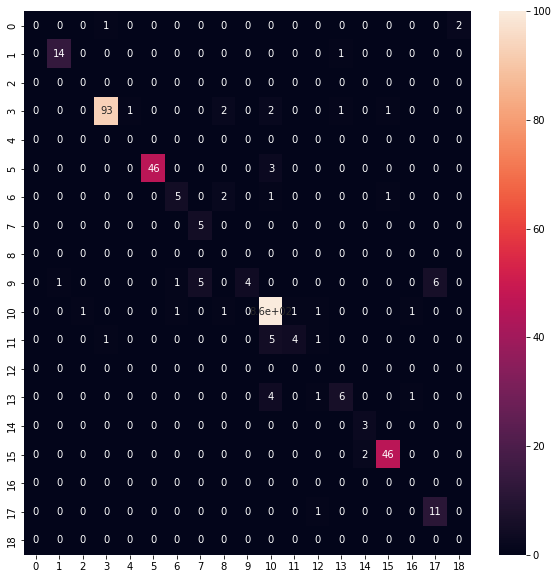

In [16]:
evaluate_model(model_LSTM, X_test, y_test)

## RNN MODEL

In [17]:
model_SimpleRNN = create_model(SimpleRNN, EMBEDDING_DIMS, EMBEDDING_SIZE, INPUT_LENGTH, UNITS, DROPOUT, LABELS)
model_SimpleRNN.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=["accuracy"])
model_SimpleRNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 48, 100)           94400     
                                                                 
 simple_rnn (SimpleRNN)      (None, 48, 128)           29312     
                                                                 
 dropout_2 (Dropout)         (None, 48, 128)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 26)                3354      
                                                                 
Total params: 159,962
Trainable params: 159,962
Non-tr

In [18]:
history = model_SimpleRNN.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs=EPOCHS,validation_split=0.15,verbose=2)

Epoch 1/8
125/125 - 18s - loss: 1.5741 - accuracy: 0.6788 - val_loss: 1.1121 - val_accuracy: 0.7518 - 18s/epoch - 142ms/step
Epoch 2/8
125/125 - 16s - loss: 1.2439 - accuracy: 0.7246 - val_loss: 1.1032 - val_accuracy: 0.7518 - 16s/epoch - 126ms/step
Epoch 3/8
125/125 - 15s - loss: 1.0245 - accuracy: 0.7537 - val_loss: 0.7149 - val_accuracy: 0.8128 - 15s/epoch - 123ms/step
Epoch 4/8
125/125 - 15s - loss: 0.7209 - accuracy: 0.8261 - val_loss: 0.5738 - val_accuracy: 0.8553 - 15s/epoch - 123ms/step
Epoch 5/8
125/125 - 15s - loss: 0.5660 - accuracy: 0.8602 - val_loss: 0.4631 - val_accuracy: 0.8908 - 15s/epoch - 123ms/step
Epoch 6/8
125/125 - 15s - loss: 0.5468 - accuracy: 0.8639 - val_loss: 0.5346 - val_accuracy: 0.8766 - 15s/epoch - 123ms/step
Epoch 7/8
125/125 - 16s - loss: 0.4013 - accuracy: 0.8975 - val_loss: 0.4148 - val_accuracy: 0.9050 - 16s/epoch - 125ms/step
Epoch 8/8
125/125 - 16s - loss: 0.3498 - accuracy: 0.9105 - val_loss: 0.4612 - val_accuracy: 0.8766 - 16s/epoch - 126ms/step


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.07      0.25      0.11         4
           2       0.00      0.00      0.00         0
           3       0.94      0.57      0.71       155
           4       0.00      0.00      0.00         0
           6       0.48      0.41      0.44        54
           8       0.00      0.00      0.00         0
           9       0.60      0.55      0.57        11
          11       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.95      0.99      0.97       843
          15       0.20      0.20      0.20         5
          17       0.00      0.00      0.00         0
          19       0.00      0.00      0.00         0
          20       0.00      0.00      0.00         0
          21       0.96      0.75      0.84        61
          23       0.00      0.00      0.00         0
          24       0.29    

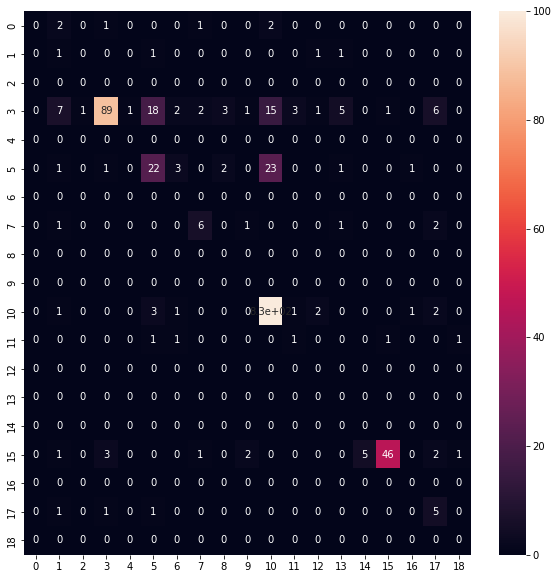

In [19]:
evaluate_model(model_SimpleRNN, X_test, y_test)

## GRU MODEL

In [20]:
model_GRU = create_model(GRU, EMBEDDING_DIMS, EMBEDDING_SIZE, INPUT_LENGTH, UNITS, DROPOUT, LABELS)
model_GRU.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=["accuracy"])
model_GRU.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 48, 100)           94400     
                                                                 
 gru (GRU)                   (None, 48, 128)           88320     
                                                                 
 dropout_4 (Dropout)         (None, 48, 128)           0         
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 26)                3354      
                                                                 
Total params: 285,146
Trainable params: 285,146
Non-tr

In [21]:
history = model_GRU.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs=EPOCHS,validation_split=0.15,verbose=2)

Epoch 1/8
125/125 - 8s - loss: 1.2140 - accuracy: 0.7304 - val_loss: 0.7114 - val_accuracy: 0.7872 - 8s/epoch - 63ms/step
Epoch 2/8
125/125 - 3s - loss: 0.6145 - accuracy: 0.8487 - val_loss: 0.4018 - val_accuracy: 0.8950 - 3s/epoch - 25ms/step
Epoch 3/8
125/125 - 3s - loss: 0.3785 - accuracy: 0.8955 - val_loss: 0.2921 - val_accuracy: 0.9248 - 3s/epoch - 25ms/step
Epoch 4/8
125/125 - 3s - loss: 0.2419 - accuracy: 0.9341 - val_loss: 0.2056 - val_accuracy: 0.9504 - 3s/epoch - 25ms/step
Epoch 5/8
125/125 - 3s - loss: 0.1442 - accuracy: 0.9617 - val_loss: 0.1835 - val_accuracy: 0.9631 - 3s/epoch - 25ms/step
Epoch 6/8
125/125 - 3s - loss: 0.0959 - accuracy: 0.9757 - val_loss: 0.1716 - val_accuracy: 0.9560 - 3s/epoch - 25ms/step
Epoch 7/8
125/125 - 3s - loss: 0.0703 - accuracy: 0.9822 - val_loss: 0.1491 - val_accuracy: 0.9631 - 3s/epoch - 25ms/step
Epoch 8/8
125/125 - 3s - loss: 0.0532 - accuracy: 0.9875 - val_loss: 0.1490 - val_accuracy: 0.9674 - 3s/epoch - 25ms/step


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.93      0.78      0.85        18
           2       0.00      0.00      0.00         0
           3       0.99      0.97      0.98        97
           4       0.00      0.00      0.00         0
           6       0.96      1.00      0.98        44
           8       0.86      0.86      0.86         7
           9       1.00      0.71      0.83        14
          11       0.60      1.00      0.75         3
          13       1.00      0.80      0.89         5
          14       0.99      0.99      0.99       869
          15       0.80      0.36      0.50        11
          17       0.75      1.00      0.86         3
          19       0.62      0.83      0.71         6
          20       0.80      1.00      0.89         4
          21       0.98      1.00      0.99        47
          23       0.00      0.00      0.00         0
          24       0.82    

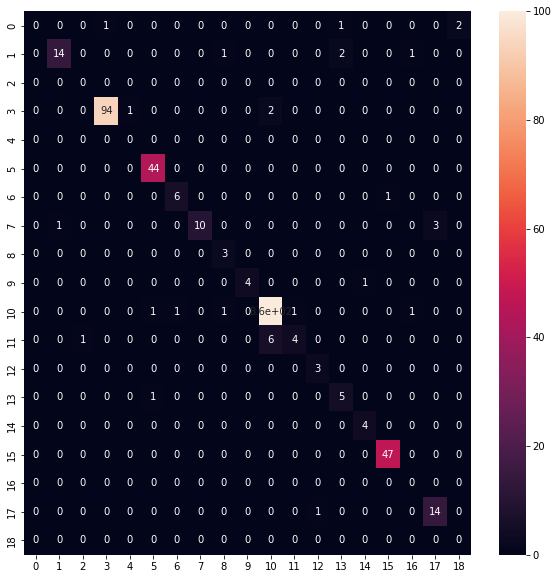

In [22]:
evaluate_model(model_GRU, X_test, y_test)